首先导入磁矩数据，此处的obj是磁矩数据中，所有磁矩的z分量，以下称为v

In [120]:
import micromagneticdata as md

data = md.Data(name="A_K",dirname="C:\\MagneticData\\EX_UNI")
obj = data[0][0].sel(z=0).z
obj((0,0)) # (0,0)点的磁矩的z分量，v

array([-1399841.64835472])

我们来看一眼磁矩数据

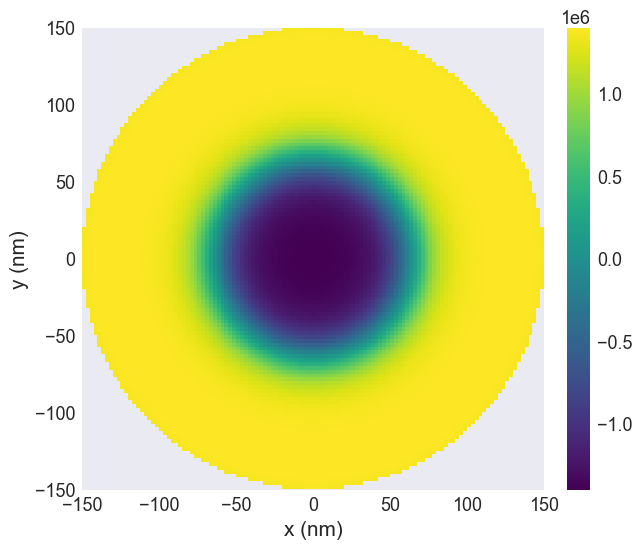

In [121]:
obj.mpl()

接下来，我们要遍历磁矩数据的每一个y值，得到一个线段对象。
通过这个线对象得到v关于x的一个离散函数。
我们将通过差值的方法，把他变成连续函数。
然后求出这个连续函数的零点，这就是斯格明子的边界位置。

首先，我们先定义求根的函数，我把进行差值和求根的过程并到一起去了。

In [123]:
from scipy.interpolate import CubicSpline # 三次样条差值
from scipy.optimize import brentq # 二分法找零点
def find_roots(x,y):
    '''
    x: 数组
    y: 数组
    这个函数通过x,y构造一个三次样条差值函数 f
    x应当是f的自变量,
    y应当是f的因变量。
    然后找到f的所有零点，并且以数组的形式返回

    return: root 是y = f(x)的所有零点
    '''
    # 进行插值
    f = CubicSpline(x, y)
    
    # 零点位置
    roots=[]    
    # x的步进
    step = 1e-9

    # 设置x的定义域
    min_x, max_x = x.min(), x.max()

    # 定义容差和最大迭代次数
    tolerance = 1e-12
    max_iterations = 100

    # 设置当前搜索位置为起始值
    current_x = min_x
    # 计算起始位置的函数值
    f_current = f(current_x)

    # 初始化下一个位置的数值
    next_x = current_x + step
    # 计算下一个位置的函数值
    f_next = f(next_x)

    # 遍历整个搜索区间
    while next_x < max_x:
        
        # 遍历搜索区域, 寻找左右异号的区间
        while f_current * f_next > 0: # 这意味着，零点不在当前区间
            # 步进一个位置
            current_x = next_x
            next_x += step      

            if next_x > max_x: # 搜索区间不能超过定义域
                break
            f_next = f(next_x)  # 更新函数值
            
        if next_x > max_x: # 搜索区间不能超过定义域
            break

        # 找到函数值异号的区间，使用brentq函数求解
        root = brentq(f, current_x, next_x, xtol=tolerance, maxiter=max_iterations)

        # 输出当前根
        roots.append(root)

        # 更新区间
        current_x = next_x
        f_current = f_next
        next_x += step
        f_next = f(next_x)

    return roots

接下来，我们要遍历磁矩数据的每一个y值，得到一个线段对象。
注意，磁矩文件中存在我们不需要的点，要把他过滤掉。
然后得到x和v的数组，并对他们使用``find_root``函数，这样就能得到所有的零点。

In [124]:
import numpy as np

# 得到所有需要遍历的y值
dy =1e-9
ypmin = obj.mesh.region.pmin[1]
ypmax = obj.mesh.region.pmax[1]
xpmin = obj.mesh.region.pmin[0]
xpmax = obj.mesh.region.pmax[0]
Y = np.linspace(ypmin,ypmax,100)

# 这是用于储存零点的两个数组
x_zero_points = []
y_zero_points = []

for y in Y:
    line = obj.line(p1=(xpmin,y),p2=(xpmax,y))
    # 找到第一个和最后一个磁矩不为零的x坐标，以这种方式过滤调不想要的点
    s = line.data['v']
    first_nonzero_index = s[s != 0].index[0]
    last_nonzero_index = s[s != 0].index[-1]
    xpmin_ = line.data['x'].loc[first_nonzero_index]
    xpmax_ = line.data['x'].loc[last_nonzero_index]
    line_ = obj.line(p1=(xpmin_,y),p2=(xpmax_,y)) # 过滤之后的线段对象

    # 求根得到
    x = line_.data['x'].values
    value = line_.data['v'].values
    roots = find_roots(x,value)
    # 把得到的零点传到两个数组中
    for x in roots:
        x_zero_points.append(x)
        y_zero_points.append(y)


此处的数组`x_zero_points`和`y_zero_points`便是得到的零点坐标

看一眼我们得到的斯格明子边界数据

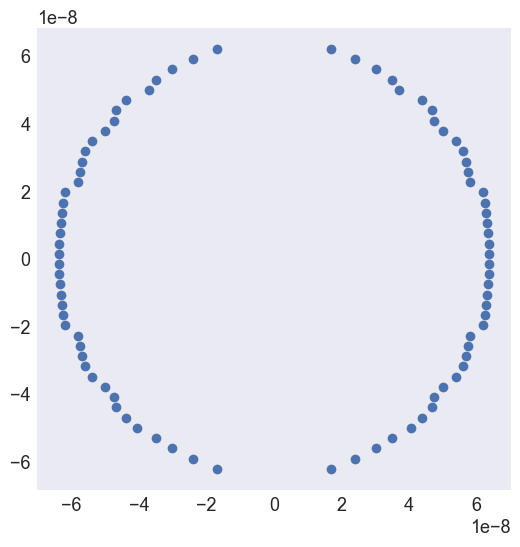

In [125]:
import matplotlib.pyplot as plt
plt.plot(x_zero_points,y_zero_points,'o')
plt.gca().set_aspect('equal', adjustable='box')

在磁矩图中展示

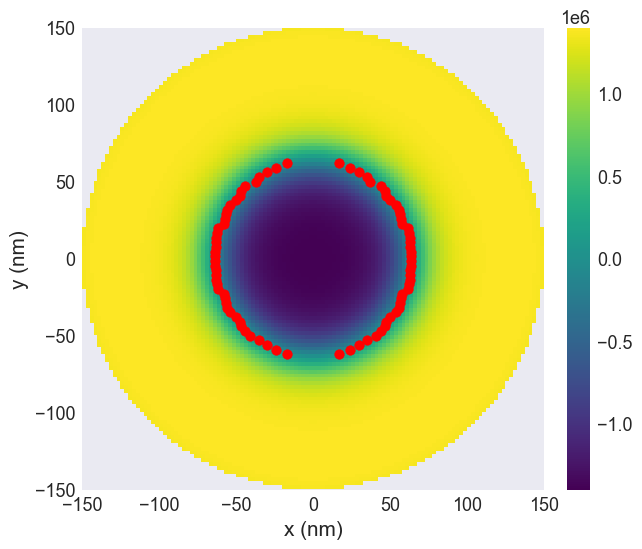

In [8]:
fig, ax = plt.subplots()
obj.mpl(ax=ax)

# 需要放大一下零点坐标，以适应obj.mpl
x_zero_points_modified = []
y_zero_points_modified = []
for i in range(len(x_zero_points)):
    y_zero_points_modified.append(y_zero_points[i]*1e9) 
    x_zero_points_modified.append(x_zero_points[i]*1e9)

ax.scatter(x_zero_points_modified,y_zero_points_modified,c='red')

可以注意到，我们得到的是在直角坐标系下的坐标，我们需要把他转换成极坐标，以进行之后的傅里叶级数展开。

In [108]:
from math import atan2,sqrt

r_sets = []
theta_sets = []

for i in range(len(x_zero_points)):
    r = sqrt(x_zero_points[i]**2+y_zero_points[i]**2)
    theta = atan2(y_zero_points[i],x_zero_points[i])
    r_sets.append(r)
    theta_sets.append(theta)

# 在这里，我还以theta为基准排了一下顺序，纯粹是为了让画图更好看
zip_r_theta = zip(r_sets, theta_sets)
sorted_zip = sorted(zip_r_theta, key=lambda x:x[1])
sorted_r, sorted_theta = zip(*sorted_zip)

看一眼成果

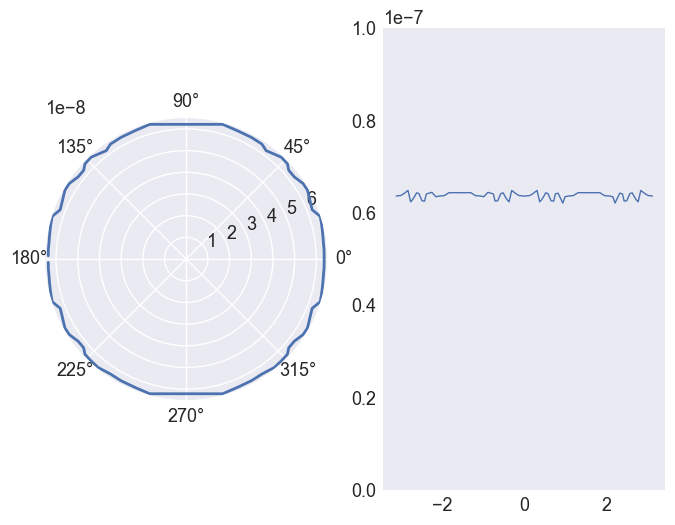

In [109]:
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='polar')
ax2 = fig.add_subplot(122)
ax2.set_ylim(0,10e-8)
ax1.plot(sorted_theta,sorted_r,lw=2)
ax2.plot(sorted_theta,sorted_r,lw=1)

接下来进行傅里叶变换，并且进行滤波处理

Text(0.5, 1.0, 'Band Pass Filtered Signal')

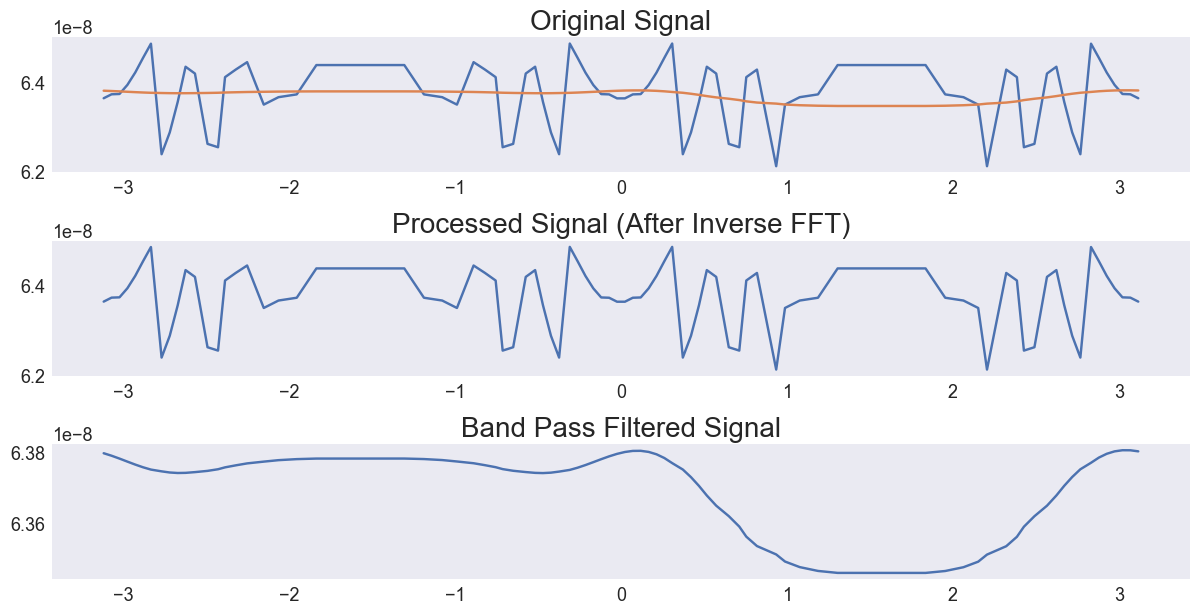

In [110]:
from scipy.fft import fft,ifft

def band_pass_filter(signal_fft, freq, cutoff_low, cutoff_high):
    """
    带通滤波器
    :param signal_fft: 信号的FFT结果
    :param freq: 频率数组
    :param cutoff_low: 低截止频率
    :param cutoff_high: 高截止频率
    :return: 滤波后的FFT结果
    """
    # 复制FFT结果以进行操作
    filtered_fft = np.copy(signal_fft)
    # 将不在截止频率范围内的成分置零
    mask = np.logical_or(np.abs(freq) < cutoff_low, np.abs(freq) > cutoff_high)
    filtered_fft[mask] = 0
    return filtered_fft

theta = list(sorted_theta)
r =list(sorted_r)

# 进行傅里叶变换
r_fft = fft(r)

# 获取频率轴的值
N = len(r)
T = theta[1] - theta[0]  # 采样间隔
freq = np.fft.fftfreq(N, T)

# 执行傅里叶逆变换
r_ifft = ifft(r_fft)

# 应用带通滤波
bpf_result = band_pass_filter(r_fft, freq, cutoff_low=0, cutoff_high=1)  # 假定截止频率为5Hz到10Hz
bpf_r = np.real(ifft(bpf_result))# 对每种滤波结果进行逆傅里叶变换以回到时域

# 绘制原始数据
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(theta, r)
plt.title('Original Signal')

# 处理后的数据（傅里叶逆变换的结果）
plt.subplot(3, 1, 2)
plt.plot(theta, np.real(r_ifft))  # 使用np.real确保忽略微小的虚部
plt.title('Processed Signal (After Inverse FFT)')
plt.tight_layout()

plt.subplot(3, 1, 1)
plt.plot(theta, bpf_r)


plt.subplot(3, 1, 3)
plt.plot(theta, bpf_r)
plt.title('Band Pass Filtered Signal')


图一中的黄线是图三中的蓝线，我们可以看到，滤波之后数据变得更加平滑，

Text(0.5, 1.0, 'after filter')

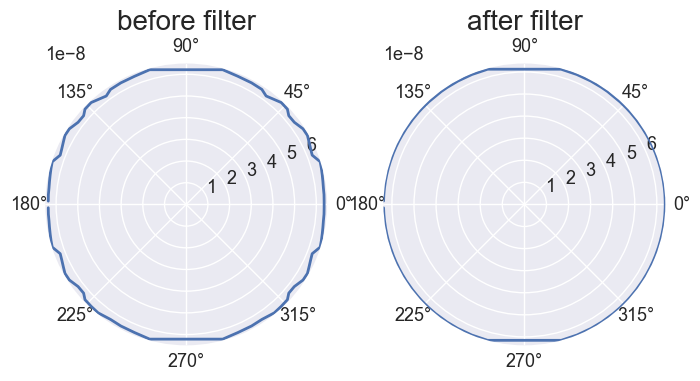

In [111]:
ax1 = plt.subplot(121, projection='polar')
ax2 = plt.subplot(122, projection='polar')
plt.gca().set_aspect('equal', adjustable='box')
ax1.plot(list(sorted_theta),list(sorted_r),lw=2)
ax2.plot(theta,bpf_r,lw=2,)
ax1.set_title('before filter')
ax2.set_title('after filter')

在磁矩图中展示

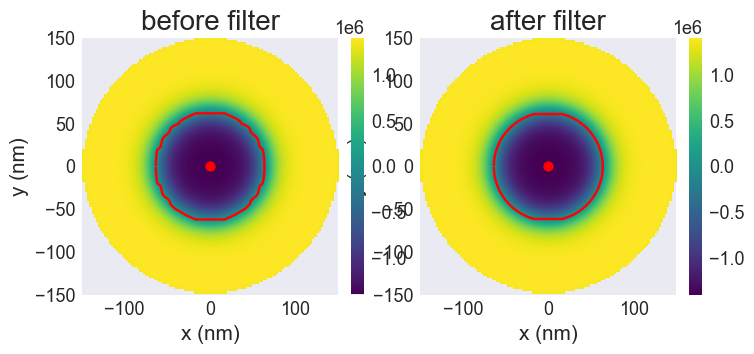

In [119]:
fig, ax = plt.subplots(1,2)
obj.mpl(ax=ax[0])
obj.mpl(ax=ax[1])

# 需要放大一下零点坐标，以适应obj.mpl
x_zero_points_modified = []
y_zero_points_modified = []
for i in range(len(x_zero_points)):
    y_zero_points_modified.append(y_zero_points[i]*1e9) 
    x_zero_points_modified.append(x_zero_points[i]*1e9)

from math import sin, cos
# 把滤波后的坐标转换成直角坐标
x_filtered = []
y_filtered = []
for i in range(len(theta)):
    x = bpf_r[i] * cos(theta[i])
    y = bpf_r[i] * sin(theta[i])
    x_filtered.append(x)
    y_filtered.append(y)

# 需要放大一下零点坐标，以适应obj.mpl
x_filtered_modified = []
y_filtered_modified = []
for i in range(len(x_filtered)):
    y_filtered_modified.append(y_filtered[i]*1e9) 
    x_filtered_modified.append(x_filtered[i]*1e9)

# 把没有滤波的极坐标转换成直角坐标
x_sorted = []
y_sorted = []
for i in range(len(sorted_theta)):
    x = sorted_r[i] * cos(sorted_theta[i])
    y = sorted_r[i] * sin(sorted_theta[i])
    x_sorted.append(x)
    y_sorted.append(y)

# 需要放大一下零点坐标，以适应obj.mpl
x_sorted_modified = []
y_sorted_modified = []
for i in range(len(x_sorted)):
    x_sorted_modified.append(x_sorted[i]*1e9) 
    y_sorted_modified.append(y_sorted[i]*1e9)


ax[0].plot(x_sorted_modified,y_sorted_modified,c='red')
ax[1].plot(x_filtered_modified,y_filtered_modified,c='red')
ax[0].set_title('before filter')
ax[1].set_title('after filter')

x_center_modified =sum(x_sorted_modified)/len(x_sorted_modified)
y_center_modified =sum(y_sorted_modified)/len(y_sorted_modified)

x_center =sum(x_filtered_modified)/len(x_filtered_modified)
y_center =sum(y_filtered_modified)/len(y_filtered_modified)

ax[0].scatter(x_center_modified,y_center_modified,c='red')
ax[1].scatter(x_center,y_center,c='red')

求一下滤波后的半径的平均值

In [114]:
sum(bpf_r)/len(bpf_r)

6.37093580915503e-08